In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Загрузить базу MNIST из предлагаемого файла digitsMnist.npy. В данном файле 
хранится массив массивов, содержащий в общей сложности 60000 образов 
рукописных цифр (размером 28 на 28 точек), выполненных в оттенках серого. При 
загрузке необходимо воспользоваться функцией load() из библиотеки Numpy, не 
забыв при этом указать параметр allow_pickle = True, поскольку загружаемый 
файл содержит вложенные структуры данных. На верхнем уровне структура 
массива, загружаемого из файла, следующая:
- по индексу 0 хранится массив образов цифр, которые необходимо 
использовать для обучения;
- по индексу 1 хранится массив меток, описывающих правильную 
классификацию для каждого образа из предыдущего пункта (метки 
задаются цифрами, а не строками);
- по индексу 2 хранится множество образов цифр, которые необходимо 
использовать в качестве валидационного множества на заключительном этапе 
оценки качества уже обученной модели;
- по индекс 3 хранится массив меток, описывающих правильную 
классификацию для каждого образа из валидационного множества (метки 
задаются цифрами а не строками).

In [3]:
data = np.load('digitsMnist.npy', allow_pickle = True)
data[1]

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

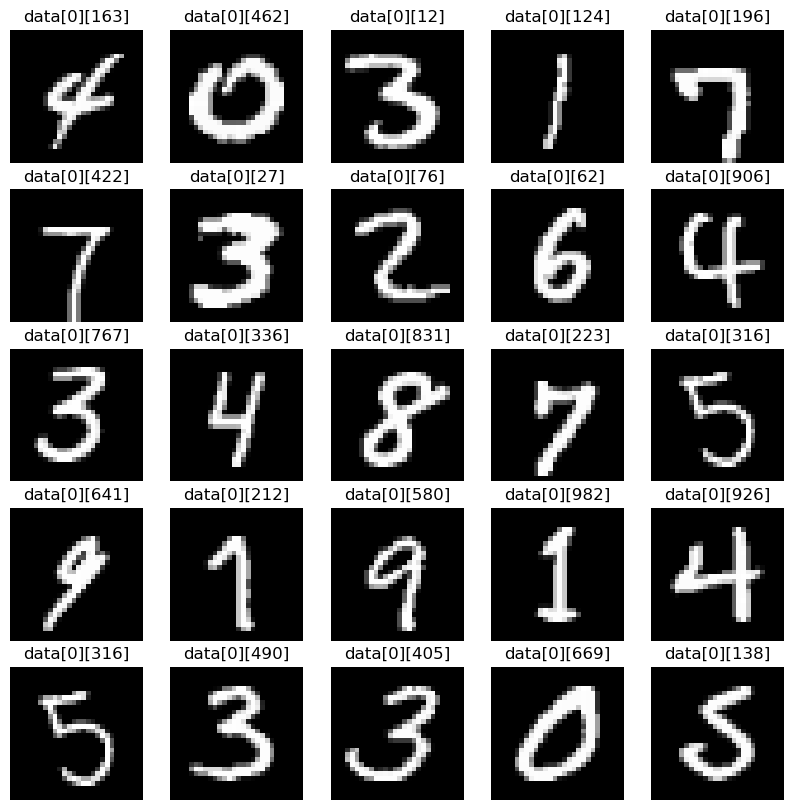

In [4]:
fig = plt.subplots(5,5, figsize = (10,10))

for i in np.arange(0, 25):
    index = np.random.randint(0, 1000)
    plt.subplot(5, 5, i+1)
    img = data[0][index].reshape(28,28)
    plt.imshow(img, cmap = 'gray')
    plt.title(f'data[0][{index}]')
    plt.axis('off')
plt.show()

При помощи условной выборки считать из загруженного в пункте 2 массива
только ту информацию, которая нужна для выполнения третьего задания согласно 
Вашему варианту. Сохранить эту информацию в 4-х отдельных переменных 
(согласно подпунктам из пункта 2), назвав их, например, так: X_forTrain, 
Y_forTrain, X_forVal, Y_forVal.

In [6]:
indexes = []

for i in range(len(data[1])):
    if (data[1][i] == 6) or (data[1][i] == 8):
        indexes.append(i)

In [7]:
X_forTrain = np.array([data[0][i] for i in indexes])
Y_forTrain = np.array([data[1][i] for i in indexes])

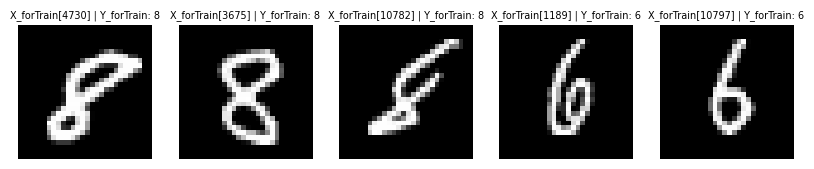

In [8]:
fig = plt.subplots(1,5, figsize = (10,10))

for i in np.arange(0, 5):
    ind = random.randint(0, len(indexes))
    plt.subplot(1, 5, i+1)
    img = X_forTrain[ind]
    res = Y_forTrain[ind]
    plt.imshow(img, cmap = 'gray')
    plt.title(f'X_forTrain[{ind}] | Y_forTrain: {res}', fontsize = 7)
    plt.axis('off')
plt.show()

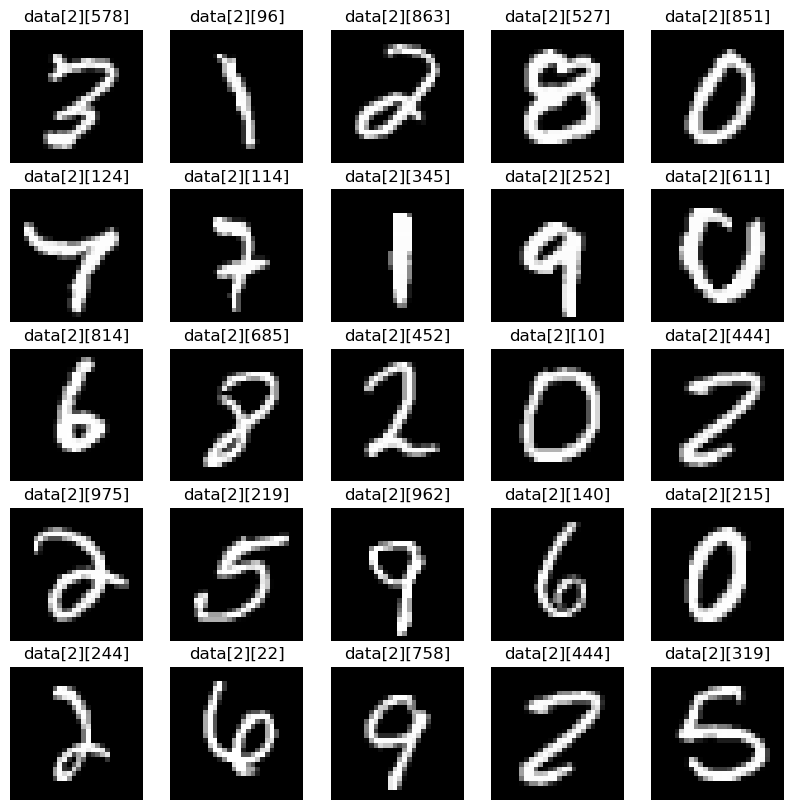

In [9]:
fig = plt.subplots(5,5, figsize = (10,10))

for i in np.arange(0, 25):
    index = np.random.randint(0, 1000)
    plt.subplot(5, 5, i+1)
    img = data[2][index].reshape(28,28)
    plt.imshow(img, cmap = 'gray')
    plt.title(f'data[2][{index}]')
    plt.axis('off')
plt.show()

In [10]:
data[3][438]

7

In [11]:
indexes = []

for i in range(len(data[3])):
    if (data[3][i] == 6) or (data[3][i] == 8):
        indexes.append(i)

In [12]:
X_forVal = np.array([data[2][i] for i in indexes])
Y_forVal = np.array([data[3][i] for i in indexes])

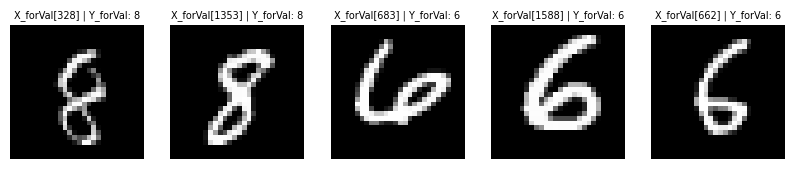

In [13]:
fig = plt.subplots(1,5, figsize = (10,10))

for i in np.arange(0, 5):
    ind = random.randint(0, len(indexes))
    plt.subplot(1, 5, i+1)
    img = X_forVal[ind]
    res = Y_forVal[ind]
    plt.imshow(img, cmap = 'gray')
    plt.title(f'X_forVal[{ind}] | Y_forVal: {res}', fontsize = 7)
    plt.axis('off')
plt.show()

 Поскольку в рамках выполнения задания 3 речь идет о бинарной классификации 
изображений, то необходимо выполнить переименование меток, хранящихся в 
переменных Y_forTrain и Y_forVal. Алгоритм обучения будет ожидать, что раз 
классов всего два, то их метки должны быть 0 и 1. Например, если согласно 
Вашему варианту, Вы должны распознать цифры 3 и 8, то будем считать, что 
образы, соответствующие цифре 3, имеют метку класса 0, а образы цифры 8 –
метку класса 1. Указанное переименование меток можно выполнить при помощи 
условной выборки над массивом Numpy с последующим присваиванием.

In [15]:
Y_forTrain = np.where(Y_forTrain == 6, 0, 1)
Y_forTrain

array([0, 1, 0, ..., 1, 0, 1])

In [16]:
Y_forVal = np.where(Y_forVal == 6, 0, 1)
Y_forVal

array([0, 0, 0, ..., 0, 1, 0])

Для того, чтобы алгоритм обучения на входе и на выходе разрабатываемой сети 
оперировал числами одного порядка, необходимо выполнить нормализацию 
значений, хранящихся в массивах X_forTrain, X_forVal. Мы знаем, что данные 
массивы описывают образы в оттенках серого, т.е. хранят интенсивности точек в 
диапазоне [0, 255], поэтому для нормализации достаточно разделить содержимое 
массивов на 255.

In [18]:
X_forTrain = X_forTrain/255
X_forVal = X_forVal/255

При помощи функции train_test_split() произвести разбиение информации, 
содержащейся в массивах X_forTrain, Y_forTrain на обучающую и тестовую 
выборки, поместив результаты разбиения в новые переменные X_train, X_test, 
Y_train, Y_test. Размер тестовой выборки (как процент от объема X_forTrain) 
задается параметром test_size, который рекомендуется задавать в пределах [0,15; 
0,30]. Для повторяемости результатов разбиения от запуска к запуску также 
рекомендуется использовать параметр random_state, присвоив ему какое-либо 
целое значение (это будет число-затравка для инициализации генератора 
псевдослучайных чисел).

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X_forTrain, 
                                                    Y_forTrain, 
                                                    test_size = 0.22, random_state = 55)

При помощи функции torch.tensor преобразовать массивы Numpy, хранящиеся в 
переменных X_train, X_test, Y_train, Y_test в тензоры, образовав новые 
переменные X_train_tensors, Y_train_tensors, X_test_tensors, Y_test_tensors. При 
этом в процессе преобразования X_train и X_test изменить тип данных на 
torch.float32 (при помощи параметра dtype), а в процессе преобразования Y_train, 
Y_test - изменить тип данных на torch.ong.

Аналогичным образом преобразовать в тензоры содержимое массивов X_forVal, 
Y_forVal, образовав новые переменные X_ val_tensors, Y_ val_tensors.

In [23]:
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype = torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype = torch.long)

In [24]:
X_val_tensors = torch.tensor(X_forVal, dtype = torch.float32)
Y_val_tensors = torch.tensor(Y_forVal, dtype = torch.long)

При помощи конструктора TensorDataset() объединить в единый тензор 
содержимое переменных X_train_tensors и Y_train_tensors (именно в таком 
порядке!), сохранив результат в новой переменной trainDataset.

Аналогичным образом объединить тензоры X_test_tensors и Y_test_tensors, 
сохранив результат в переменной testDataset

Повторить операцию для тензоров X_ val_tensors, Y_ val_tensors, образовав 
переменную valDataset.

In [28]:
trainDataset = TensorDataset(X_train_tensor, Y_train_tensor)

In [29]:
testDataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [30]:
valDataset = TensorDataset(X_val_tensors, Y_val_tensors)

При помощи конструктора DataLoader(), применяемого к содержимому 
переменной trainDataset и дополнительных параметров batch_size и shuffle, 
создать итератор, который в процессе обучения будет выдавать случайные 
подмножества заданного размера из trainDataset (т.е. батчи). Размер батча 
(batch_size) является варьируемым параметром, существенно влияющим на ход и 
результаты процесса обучения, т.е. подбирается экспериментально для 
достижения целей заданий. Параметр shuffle отвечает за предварительное 
перемешивание содержимого trainDataset и должен быть установлен в true. 
Созданный итератор следует поместить в переменную train_loader.

Аналогичным образом создать итератор для переменной testDataset (размер 
батча такой же, как в предыдущем случае) и поместить его в переменную 
test_loader.

Повторить операцию для переменной valDataset и поместить итератор в 
переменную val_loader

In [34]:
train_loader = DataLoader(trainDataset, batch_size = 7, shuffle = True)

In [35]:
test_loader = DataLoader(testDataset, batch_size = 7, shuffle = True)

In [36]:
val_loader = DataLoader(valDataset, batch_size = 7, shuffle = True)

**Создание класса, описывающего структуру сети**

In [38]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.fc1 = nn.Linear(784, 472)
        #self.fc2 = nn.Linear(628, 472)
        #self.fc3 = nn.Linear(472, 316)
        #self.fc4 = nn.Linear(472, 160)
        self.fc5 = nn.Linear(472, 2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        
        return x

Создадим экземпляр сети и разместим его в одноименной переменной.

In [40]:
simplenet = SimpleNet()

 Зададим оптимизатор, который будет использоваться в процессе обучения. 
Алгоритм оптимизации Adam является одной из наиболее гибких реализаций метода 
градиентного спуска. В отличие от других алгоритмов Adam управляет скоростью 
обучения каждой связи внутри сети индивидуально.

In [42]:
optimizer = optim.Adam(simplenet.parameters(), lr = 0.01)

Определение предпочтительного вычислителя среди доступных и его 
назначение для обработки сети.

In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=472, bias=True)
  (fc5): Linear(in_features=472, out_features=2, bias=True)
  (relu): ReLU()
)

Назначение функции, которая будет использоваться для вычисления ошибки 
сети.

In [46]:
loss_fn = torch.nn.CrossEntropyLoss()

Организуется цикл по эпохам обучения от 1 до их максимального количества, 
которое является подбираемым параметром.
Инициализация переменных для накопления величины ошибок по выборкам

In [48]:
epochs = 25

for epoch in range(epochs):
    training_loss = 0.0
    test_loss = 0.0

    #TRAINING
    for batch in train_loader: #Организуется цикл по батчам из итератора train_loader
        optimizer.zero_grad() #Обнуляем градиенты весов сети внутри оптимизатора перед каждым шагом обучения.
    
        inputs, targets = batch #Извлекаем из батча тензоры входных данных и соответствующих им меток классов.
        inputs = inputs.to(device) #Обнуляем градиенты весов сети внутри оптимизатора перед каждым шагом обучения.
        targets = targets.to(device)
        output = simplenet(inputs) #Получаем предсказания сети относительно входных данных рассматриваемого батча.

        """ Вычисляем функцию потерь, сопоставляя предсказанные значения и 
        правильные ответы. По умолчанию функция возвращает среднее значение ошибки по 
        всем примерам в батче """
        loss = loss_fn(output, targets)
        loss.backward() #Вычисляем градиенты для весов всех связей внутри сети, основываясь на значении функции потерь.

        optimizer.step() #Обновляем значения весов сети, основываясь на результатах предыдущего шага.

        """Накапливаем значение потерь по всей обучающей выборке, 
        умножая среднюю ошибку по элементам батча на размер батча"""
        training_loss += loss.data.item() * inputs.size(0)

    num_correct = 0 #Объявляем переменную для накопления количества правильных предсказаний

    #TESTING
    for batch in test_loader: #Организуется цикл по батчам из итератора test_loader
        inputs, targets = batch
        inputs = inputs.to(device) 
        targets = targets.to(device)
        output = simplenet(inputs)

        loss = loss_fn(output, targets)
        test_loss += loss.data.item() * inputs.size(0)

        """Сравниваем предсказанные классы (индексы максимумов тензора 
        softmax(output) с истинными метками классов. В результате получаем логический 
        тензор, где True соответствует правильным предсказаниям."""
        correct = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], targets)
        num_correct += torch.sum(correct).item() #Накопление количества правильных предсказаний по батчам путем суммирования всех значений True

    print(f'Эпоха: {epoch + 1}, Ошибка по обучающей выборке: {round(training_loss, 2)}, Ошибка по тестовой выборке: {round(test_loss, 2)},\
            Точность: {round(num_correct/len(X_test), 2)}')

    num_correct = 0
    
    #VALIDATION
    for batch in val_loader:
        inputs, targets = batch
        inputs = inputs.to(device) 
        targets = targets.to(device)
        output = simplenet(inputs)

        correct = torch.eq(torch.max(F.softmax(output, dim = 1), dim = 1)[1], targets)
        num_correct += torch.sum(correct).item()

print(f'Точность по валидационной выборке: {round(num_correct/len(X_forVal), 2)}')

Эпоха: 1, Ошибка по обучающей выборке: 28784.12, Ошибка по тестовой выборке: 8410.73,            Точность: 0.95
Эпоха: 2, Ошибка по обучающей выборке: 28449.89, Ошибка по тестовой выборке: 8396.34,            Точность: 0.9
Эпоха: 3, Ошибка по обучающей выборке: 28417.4, Ошибка по тестовой выборке: 8394.83,            Точность: 0.96
Эпоха: 4, Ошибка по обучающей выборке: 28392.65, Ошибка по тестовой выборке: 8408.4,            Точность: 0.94
Эпоха: 5, Ошибка по обучающей выборке: 28347.12, Ошибка по тестовой выборке: 8405.1,            Точность: 0.97
Эпоха: 6, Ошибка по обучающей выборке: 28369.9, Ошибка по тестовой выборке: 8429.35,            Точность: 0.95
Эпоха: 7, Ошибка по обучающей выборке: 28348.51, Ошибка по тестовой выборке: 8393.95,            Точность: 0.96
Эпоха: 8, Ошибка по обучающей выборке: 28327.48, Ошибка по тестовой выборке: 8405.2,            Точность: 0.97
Эпоха: 9, Ошибка по обучающей выборке: 28331.7, Ошибка по тестовой выборке: 8396.89,            Точность: 0.97